# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution, expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.experimental.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG

In [3]:
#mpl.rcParams['figure.dpi'] = 100

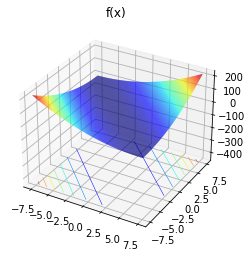

In [4]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Let's start with Guassian Problem


Shows basic flow model is working (IAF clearly very expressive), if we use a friendly gaussian relatively well suited to the pior <br>
We see here that KL and DReG get very similar results

## Setup

In [5]:
torch.manual_seed(2)
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim, scale_covariance=1)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))

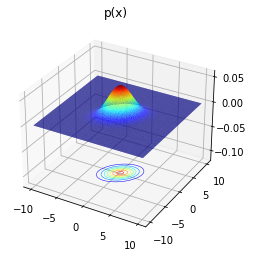

In [6]:
fig = plot_distribution(target)

## Flow with DReG - well suited prior

In [7]:
epochs = 1000
batch_size = 100

In [8]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

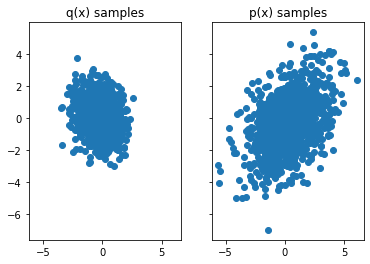

In [9]:
samples_fig_before = plot_samples(tester)

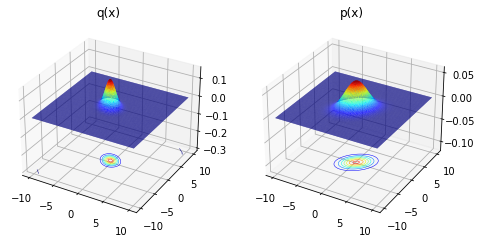

In [10]:
fig_before_train = plot_distributions(tester)

In [11]:
history = tester.train(epochs, batch_size=batch_size)

loss: -0.002217274159193039, mean log p_x -3.8659722805023193: 100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.10it/s]


In [12]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 8.210801124572754 
estimate before training is 7.371506214141846 
estimate after training is 8.111334800720215 
effective sample size before is 250.00527954101562 out of 10000
effective sample size after train is 9990.80078125  out of 10000
variance in weights is 9.207455110848972e-12


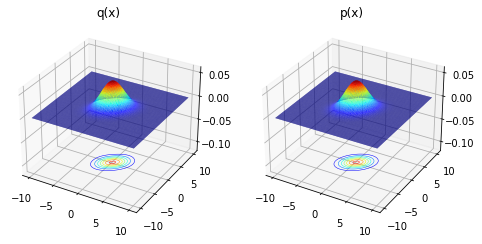

In [13]:
fig_after_train = plot_distributions(tester)

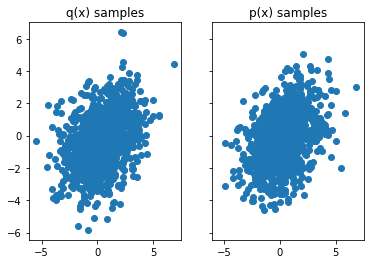

In [14]:
samples_fig_after = plot_samples(tester)

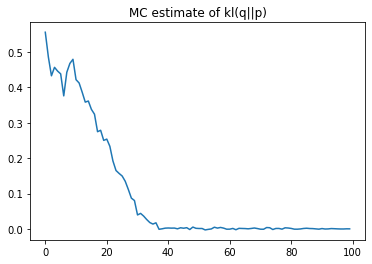

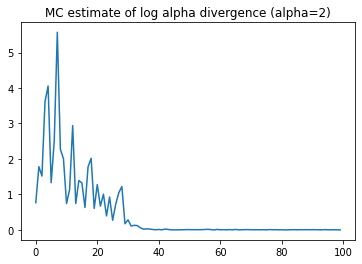

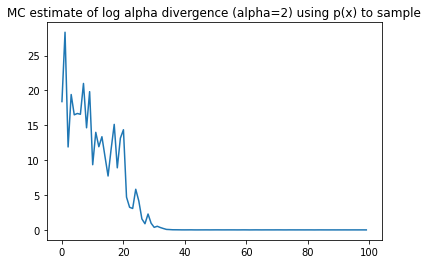

In [15]:
plot_divergences(history)

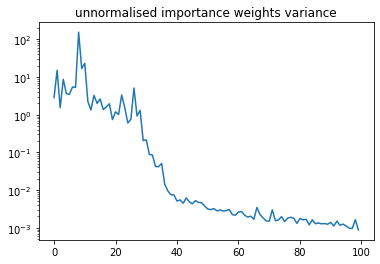

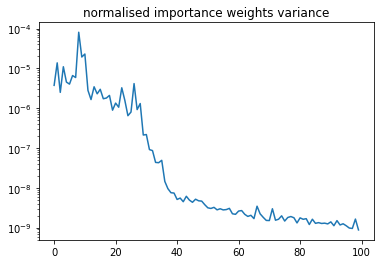

In [16]:
plot_sampling_info(history)

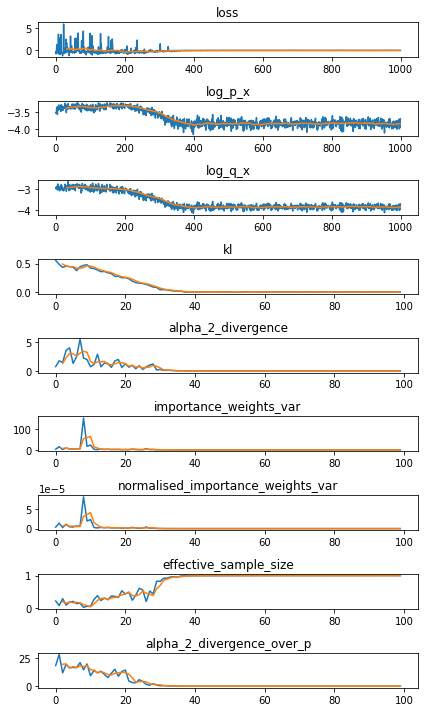

In [17]:
hist_fig = plot_history(history)

## Flow with MC alpha div
does terribly

In [18]:
"""
epochs = 100
batch_size = 100
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="alpha_MC", alpha=2)
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester)
fig_before_train = plot_distributions(tester)
history = tester.train(epochs, batch_size=batch_size)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

fig_after_train = plot_distributions(tester)
samples_fig_after = plot_samples(tester)
plot_divergences(history)
plot_sampling_info(history)
plot_history(history)
"""

'\nepochs = 100\nbatch_size = 100\ntorch.manual_seed(0)\nlearnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)\ntester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="alpha_MC", alpha=2)\nexpectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)\nsamples_fig_before = plot_samples(tester)\nfig_before_train = plot_distributions(tester)\nhistory = tester.train(epochs, batch_size=batch_size)\nexpectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)\n\nprint(f"True expectation estimate is {true_expectation} \n"\n    f"estimate before training is {expectation_before} \n"\n      f"estimate after training is {expectation} \n" \n     f"effective sample size before is {info_before[\'effective_sample_size\']} out of {n_samples_estimation}\n"\n     f"effective sample size after train is {info[\'effective_sample_size\']}  out of {n_samples_estimation}\n"\n     f"v

## Flow with KL - nice prior

In [19]:
epochs = 1000
batch_size = 100

In [20]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

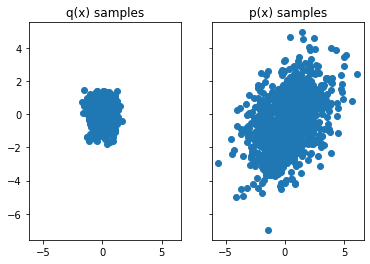

In [21]:
samples_fig_before = plot_samples(tester)

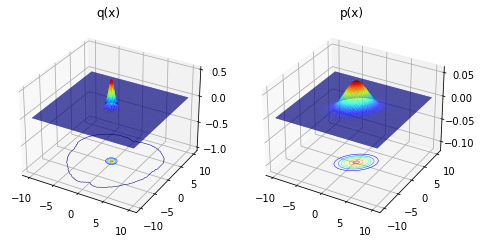

In [22]:
fig_before_train = plot_distributions(tester)

In [23]:
history = tester.train(epochs, batch_size=batch_size)

loss: 0.9462670683860779, mean log p_x -3.143451452255249: 100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.41it/s]


In [24]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 8.210801124572754 
estimate before training is 4.5573344230651855 
estimate after training is 3.9751033782958984 
effective sample size before is 250.00527954101562 out of 10000
effective sample size after train is 364.63165283203125  out of 10000
variance in weights is 2.6427579769006115e-07


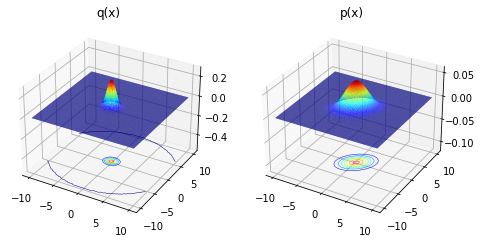

In [25]:
fig_after_train = plot_distributions(tester)

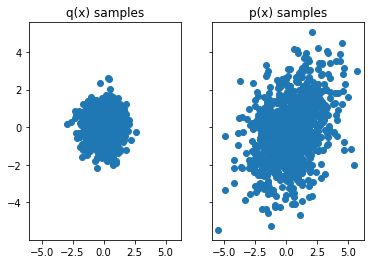

In [26]:
samples_fig_after = plot_samples(tester)

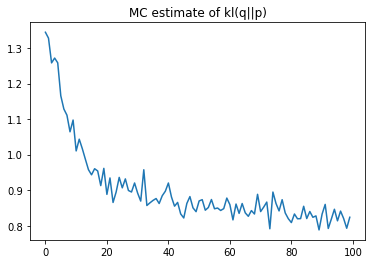

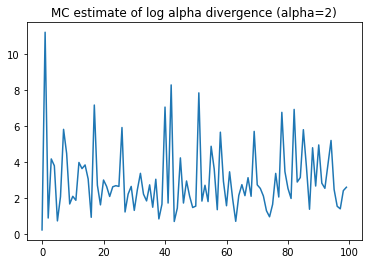

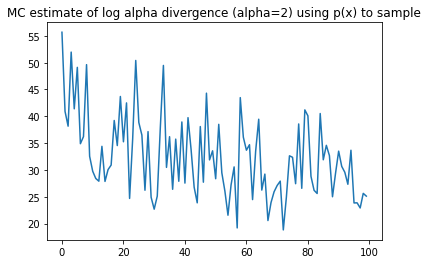

In [27]:
plot_divergences(history)

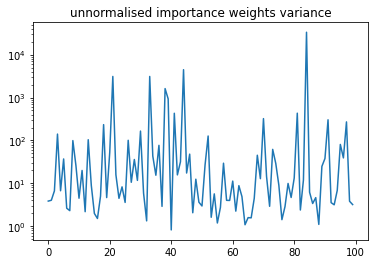

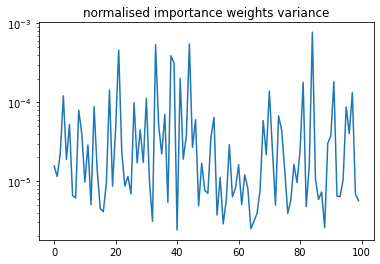

In [28]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

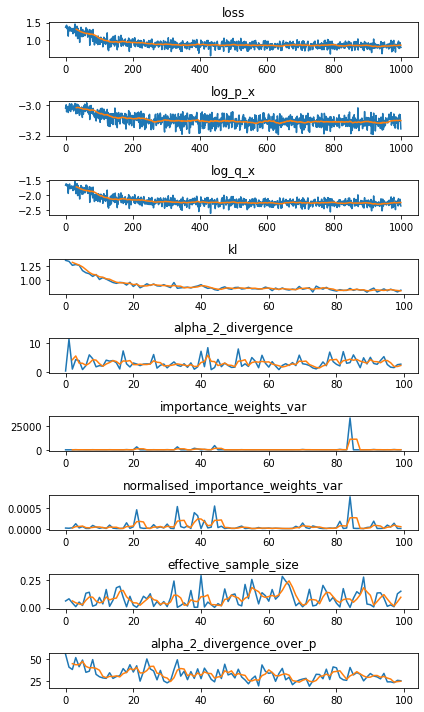

In [29]:
plot_history(history)

## Setup nastier prior

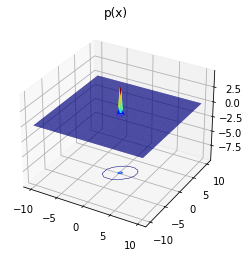

In [30]:
torch.manual_seed(2)
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim, scale_covariance=0.01)
fig = plot_distribution(target)

## Flow with DReG - poorly suited prior

In [32]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
#expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

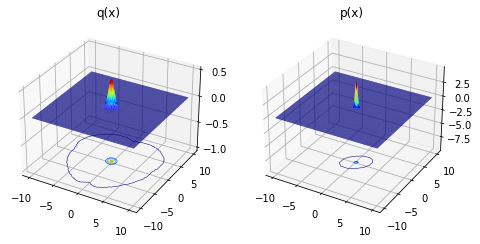

In [33]:
fig_before_train = plot_distributions(tester)

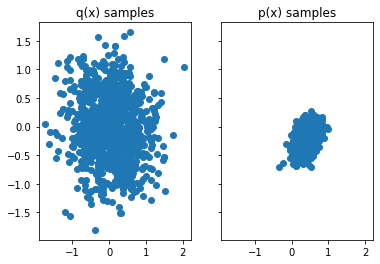

In [34]:
samples_fig_before = plot_samples(tester)

In [35]:
history = tester.train(epochs, batch_size=batch_size)

loss: -0.0012541016330942512, mean log p_x 0.7003081440925598: 100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.41it/s]


In [36]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 8.210801124572754 
estimate before training is 4.5573344230651855 
estimate after training is 0.10760936141014099 
effective sample size before is 250.00527954101562 out of 10000
effective sample size after train is 9964.2197265625  out of 10000
variance in weights is 3.5908859219446754e-11


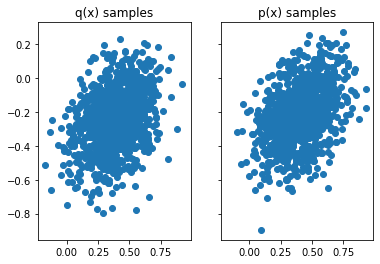

In [37]:
samples_fig_after = plot_samples(tester)

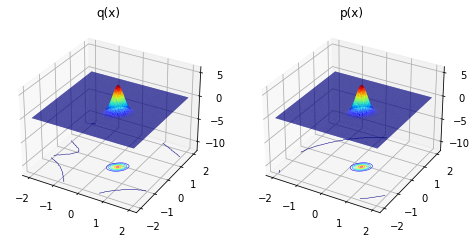

In [38]:
fig_after_train = plot_distributions(tester, bounds = [[-2, 2],[-2, 2]])

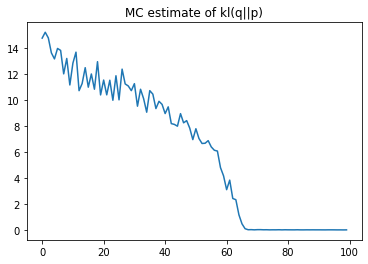

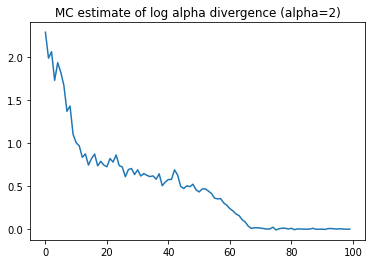

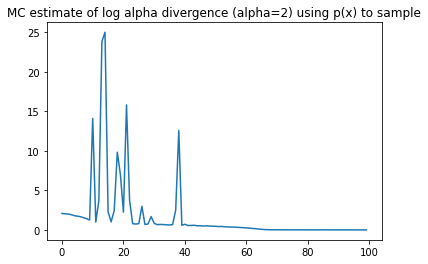

In [39]:
plot_divergences(history)

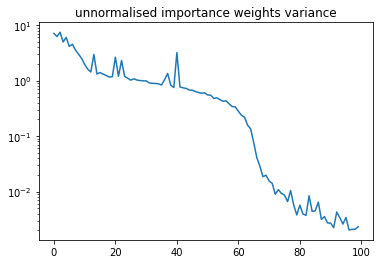

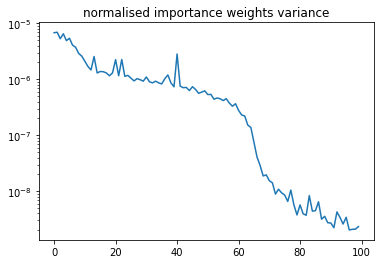

In [40]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

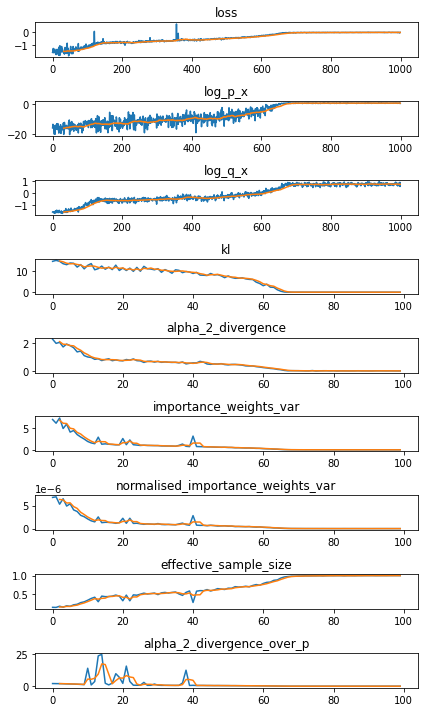

In [41]:
plot_history(history)

## Flow with kl - poorly suited prior

In [42]:
torch.manual_seed(0) 
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

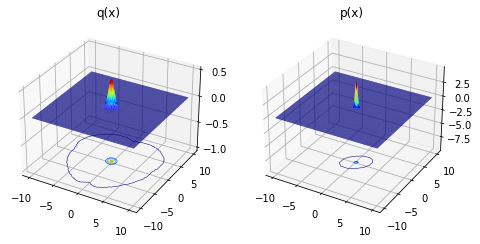

In [43]:
dist_before = plot_distributions(tester)
# below plot if we want to look in specific zone
#flow_only = plot_distribution(tester.learnt_sampling_dist, bounds = [[-100, 0],[-10, 10]], n_points=200)

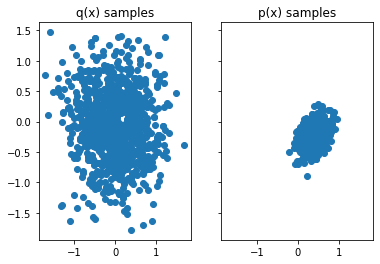

In [44]:
samples_fig_before = plot_samples(tester)

In [45]:
history = tester.train(epochs, batch_size=batch_size)

loss: 0.02946513704955578, mean log p_x 0.7979866862297058: 100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.66it/s]


In [46]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 8.210801124572754 
estimate before training is 0.11158312112092972 
estimate after training is 0.10938280075788498 
effective sample size before is 250.00527954101562 out of 10000
effective sample size after train is 9812.0927734375  out of 10000
variance in weights is 1.9152385233311975e-10


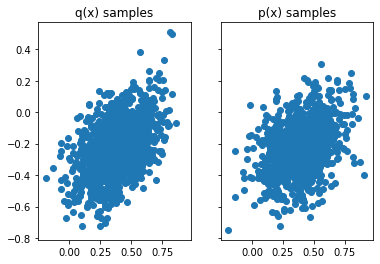

In [47]:
samples_fig_after = plot_samples(tester)

In [49]:
#fig_after_train = plot_distributions(tester)

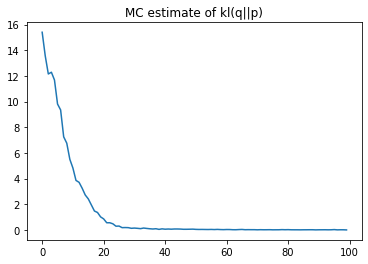

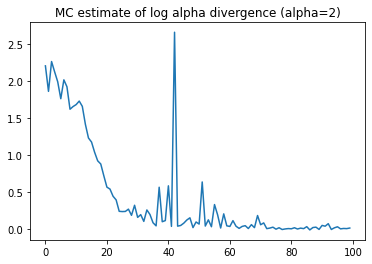

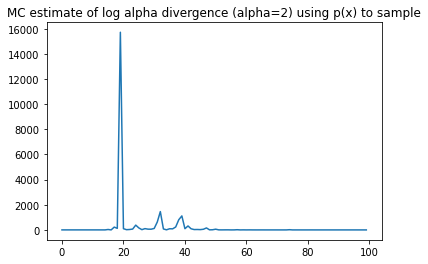

In [50]:
plot_divergences(history)

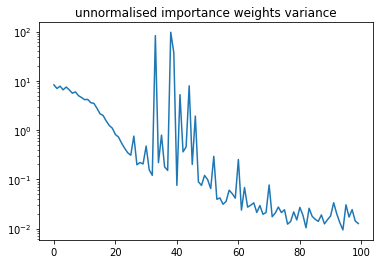

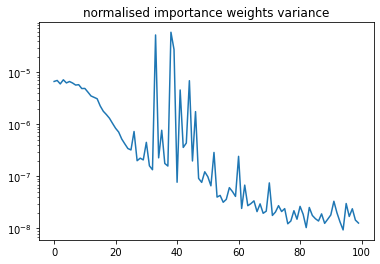

In [51]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

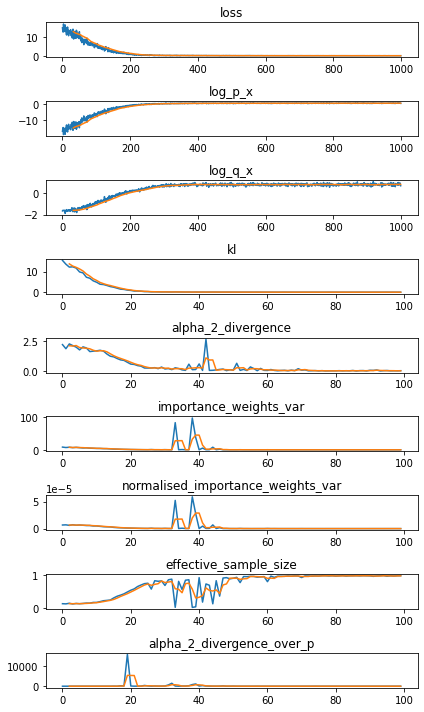

In [52]:
plot_history(history)

## Let's compare to our standard diagonal guassian case to show that flows help

In [ ]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation()

In [ ]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation)
true_expectation = torch.sum(tester.target_dist.mean)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

# Easy MoG

## Setup

tensor(4.5998)

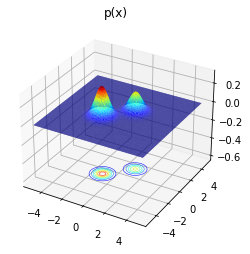

In [53]:
torch.manual_seed(6)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
#target = MoG(dim=dim, n_mixes=2, min_cov=0.01, loc_scaling=0.8)
target = custom_MoG(dim=dim, cov_scaling=0.3)
fig = plot_distribution(target, bounds=[[-5, 5], [-5, 5]])
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
true_expectation

## DReG

### Let's train for a bit

In [54]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", k=None)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

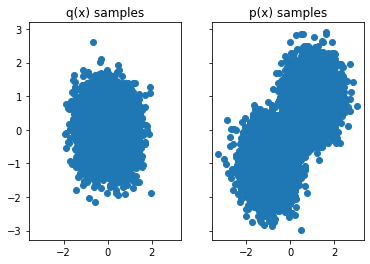

In [55]:
samples_before = plot_samples(tester, n_samples=int(1e4))

In [56]:
history = tester.train(1000, batch_size=int(1e3))

loss: -0.6208207011222839, mean log p_x -2.3937792778015137: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.15it/s]


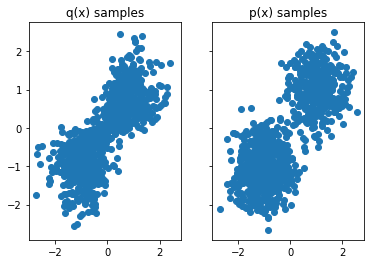

In [57]:
samples_fig_after = plot_samples(tester)

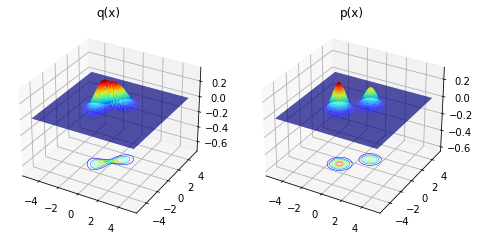

In [58]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

In [59]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 4.599788188934326 
estimate before training is 5.453876972198486 
estimate after training is 4.669642925262451 
effective sample size before is 43.48492431640625 out of 10000
effective sample size after train is 6898.7978515625  out of 10000
variance in weights is 4.495730898668171e-09


(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

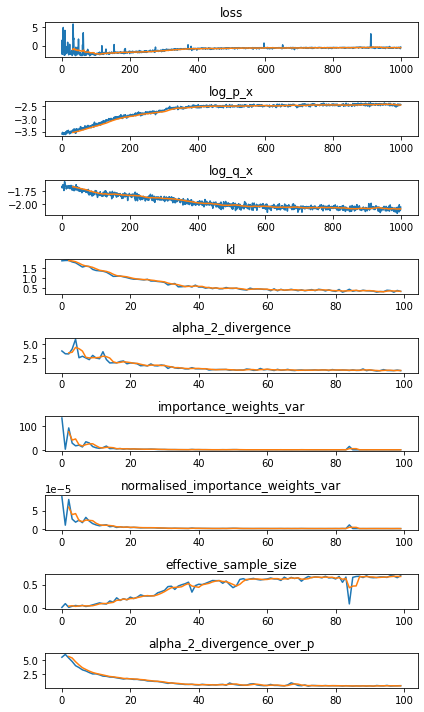

In [60]:
plot_history(history)

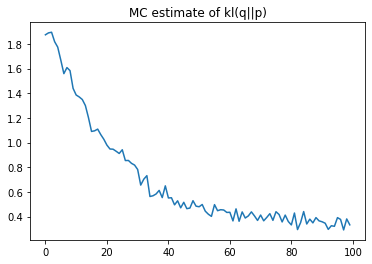

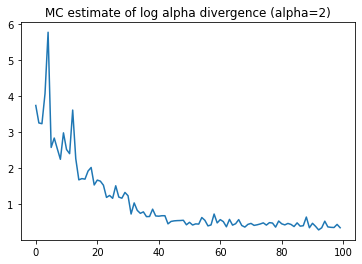

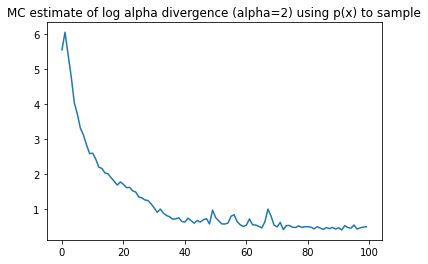

In [61]:
plot_divergences(history)

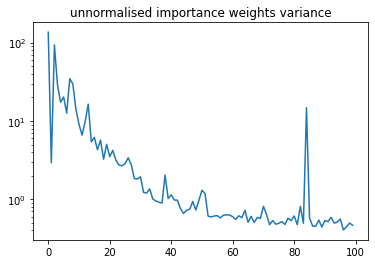

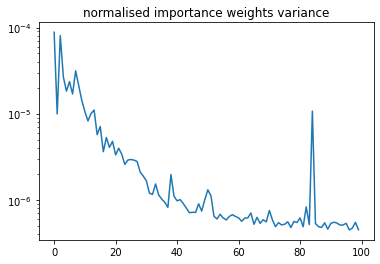

In [62]:
plot_sampling_info(history)

### Train more and it carries on getting better

In [63]:
history = tester.train(5000, batch_size=int(1e3))

loss: -0.30100515484809875, mean log p_x -2.4757540225982666: 100%|████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:57<00:00, 13.99it/s]


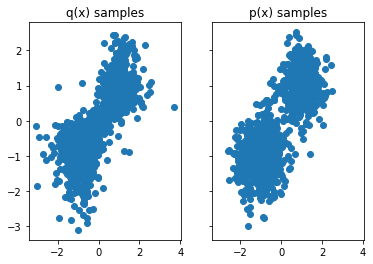

In [64]:
samples_fig_after = plot_samples(tester)

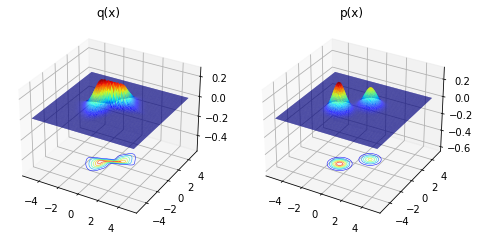

In [65]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

In [66]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 4.599788188934326 
estimate before training is 5.453876972198486 
estimate after training is 4.675966262817383 
effective sample size before is 43.48492431640625 out of 10000
effective sample size after train is 7839.431640625  out of 10000
variance in weights is 2.756297634576299e-09


(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

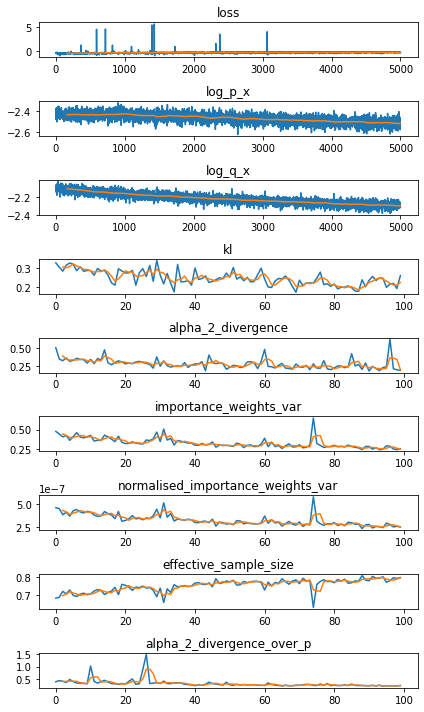

In [67]:
plot_history(history)

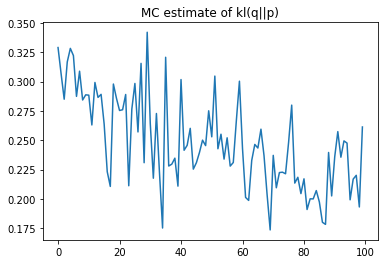

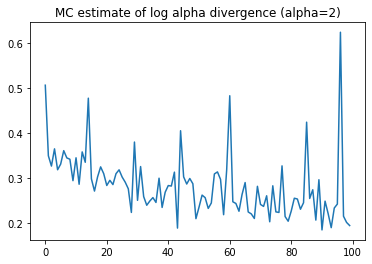

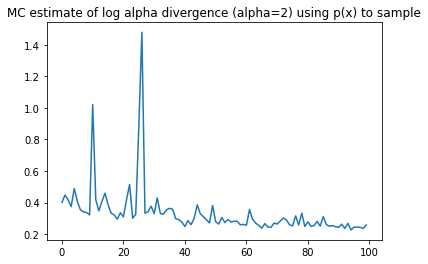

In [68]:
plot_divergences(history)

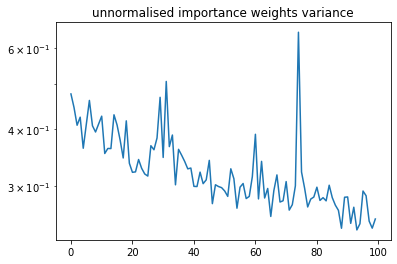

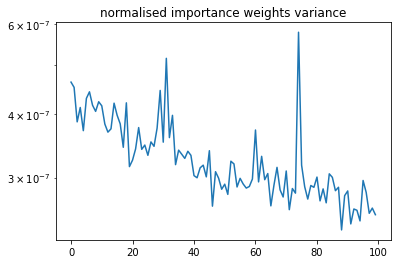

In [69]:
plot_sampling_info(history)

## kl

In [72]:
torch.manual_seed(0) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

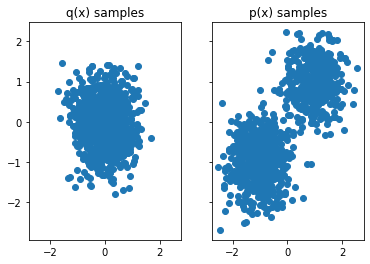

In [73]:
samples_before = plot_samples(tester)

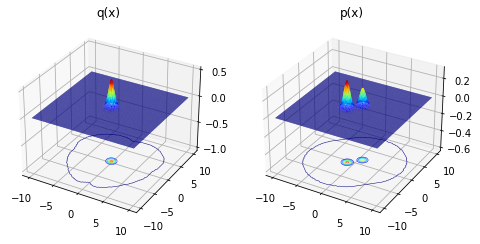

In [74]:
fig_before_train = plot_distributions(tester)

In [75]:
history = tester.train(1000, batch_size=100) # epochs 1000

loss: 0.43067246675491333, mean log p_x -2.4020657539367676: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.09it/s]


In [76]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 4.599788188934326 
estimate before training is 5.453876972198486 
estimate after training is 4.586287498474121 
effective sample size before is 43.48492431640625 out of 10000
effective sample size after train is 2965.50439453125  out of 10000
variance in weights is 2.3723444542156358e-08


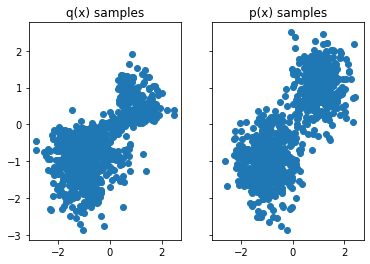

In [77]:
samples_after = plot_samples(tester)

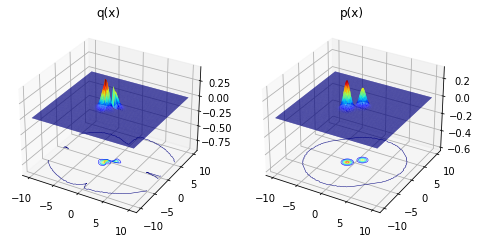

In [78]:
fig_after_train = plot_distributions(tester)

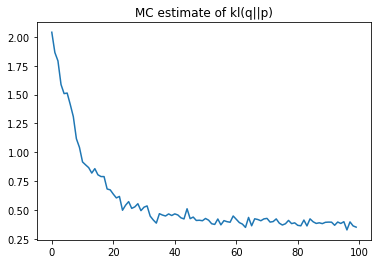

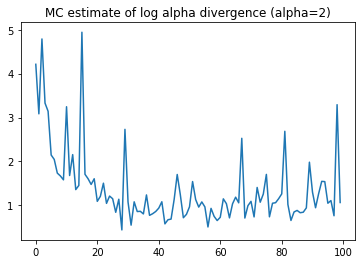

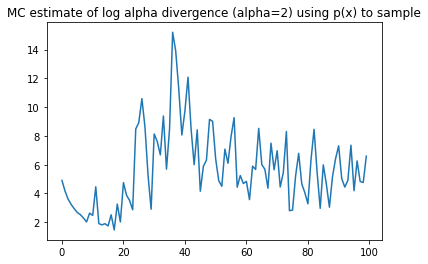

In [79]:
plot_divergences(history)

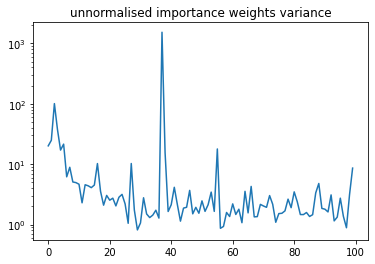

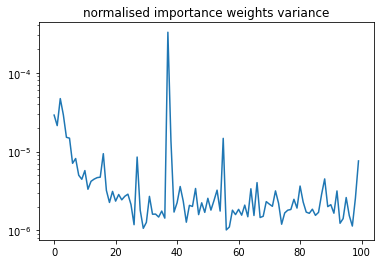

In [80]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

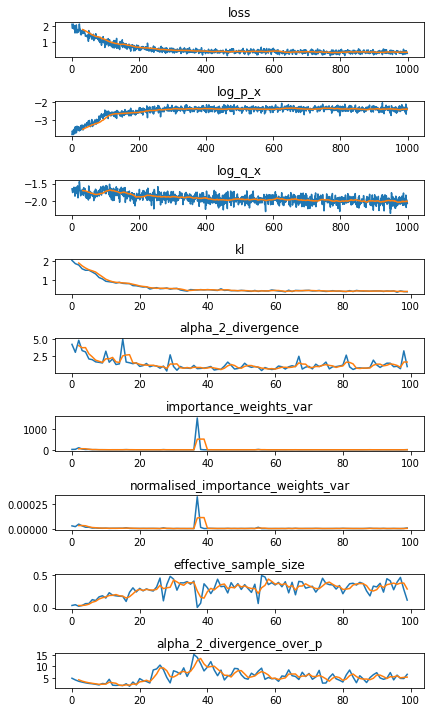

In [81]:
plot_history(history)

## DReG with alpha = 0.05

In [82]:
torch.manual_seed(0) # 1 we get a pathological case
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=5) #  , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", alpha=0.05) # "kl"

In [83]:
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

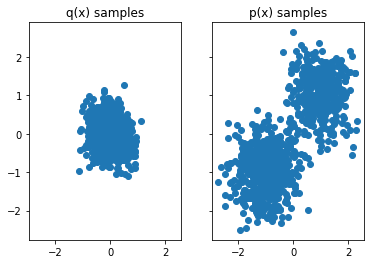

In [84]:
samples_before = plot_samples(tester)

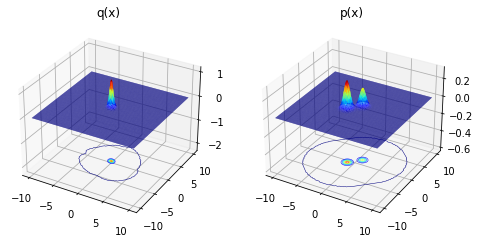

In [85]:
fig_before_train = plot_distributions(tester)

In [86]:
history = tester.train(10000, batch_size=100)

loss: 0.030488772317767143, mean log p_x -2.441490411758423: 100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:39<00:00, 21.76it/s]


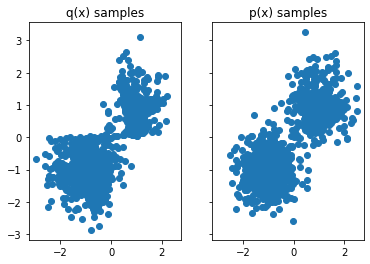

In [87]:
samples_fig_after = plot_samples(tester)

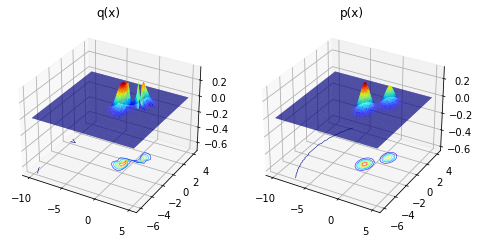

In [88]:
fig_after_train = plot_distributions(tester, bounds=[[-10, 5], [-6, 4]])

In [89]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 4.599788188934326 
estimate before training is 3.3877944946289062 
estimate after training is 4.552788257598877 
effective sample size before is 4.3599982261657715 out of 10000
effective sample size after train is 4904.78662109375  out of 10000
variance in weights is 1.0389287652401435e-08


(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

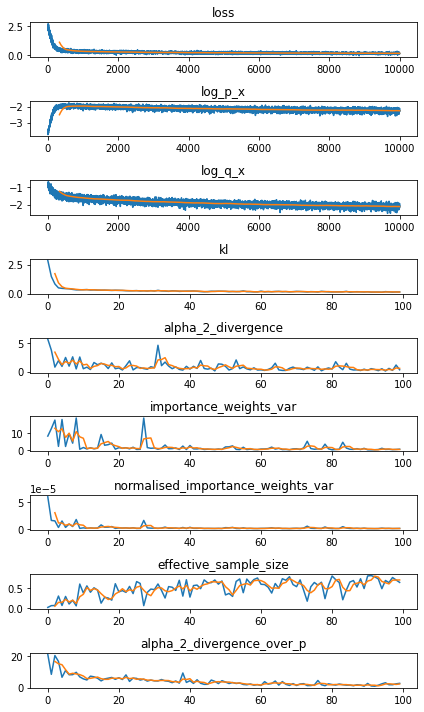

In [90]:
plot_history(history)

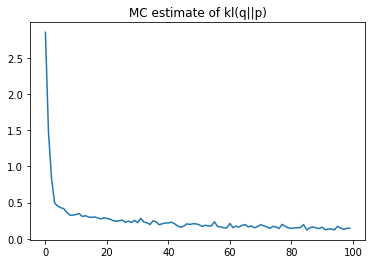

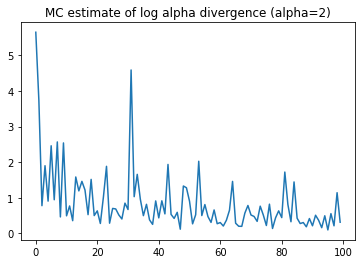

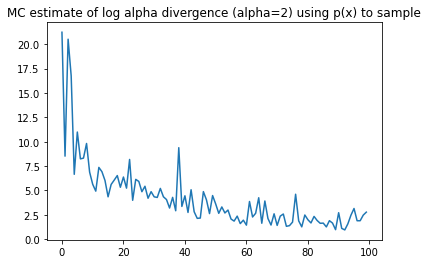

In [91]:
plot_divergences(history)

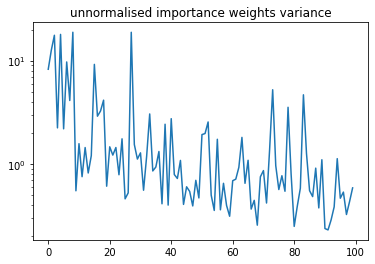

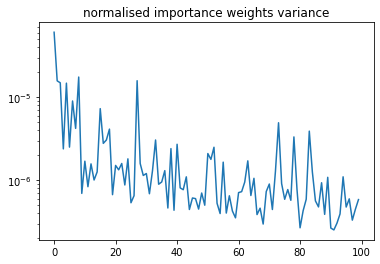

In [92]:
plot_sampling_info(history)

# Steep Difficult MoG

## Setup

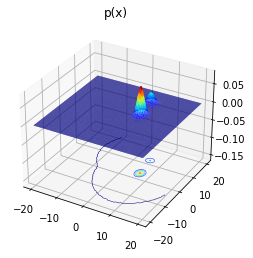

In [93]:
torch.manual_seed(1)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=2, min_cov=1, loc_scaling=10)
fig = plot_distribution(target, bounds=[[-20, 20], [-20, 20]])

## DReG

In [94]:
torch.manual_seed(1) 
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3, scaling_factor=5) #, flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")#, alpha=0.05) # "kl"

In [95]:
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

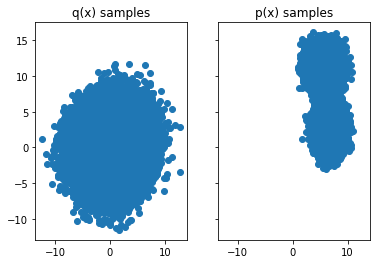

In [96]:
samples_before = plot_samples(tester, n_samples=int(1e5))

In [97]:
history = tester.train(1000, batch_size=int(1e3))

loss: -1.165469765663147, mean log p_x -23.75784683227539: 100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.28it/s]


In [98]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 4.599788188934326 
estimate before training is 95.39286041259766 
estimate after training is 88.52823638916016 
effective sample size before is 128.14483642578125 out of 10000
effective sample size after train is 2412.546142578125  out of 10000
variance in weights is 3.145313343111411e-08


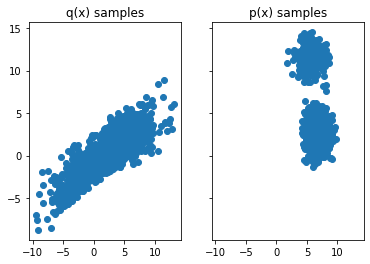

In [99]:
samples_fig_after = plot_samples(tester)

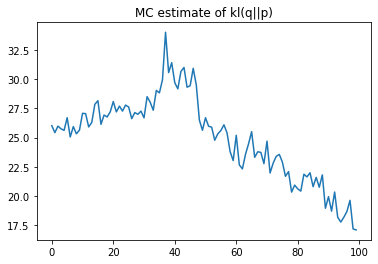

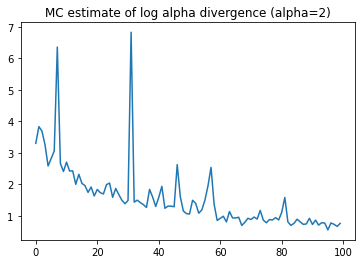

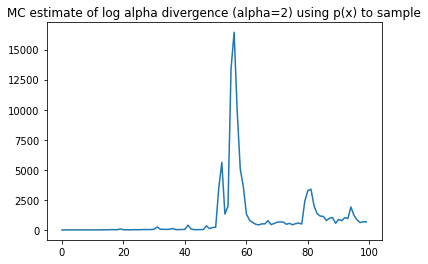

In [100]:
plot_divergences(history)

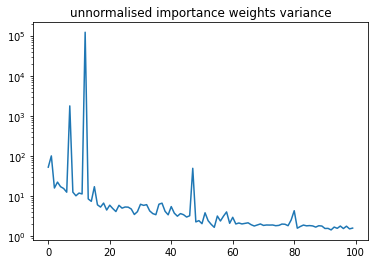

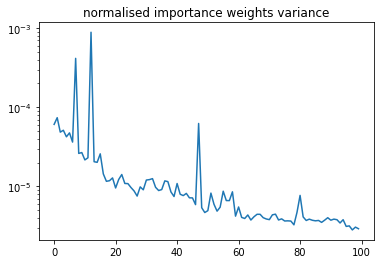

In [101]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

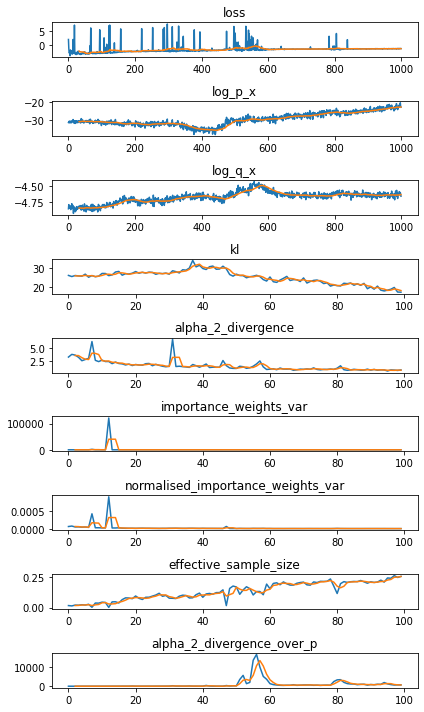

In [102]:
plot_history(history)

### But if we train for longer

In [103]:
history = tester.train(1000, batch_size=int(1e3))

loss: 0.009319044649600983, mean log p_x -6.101646900177002: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.71it/s]


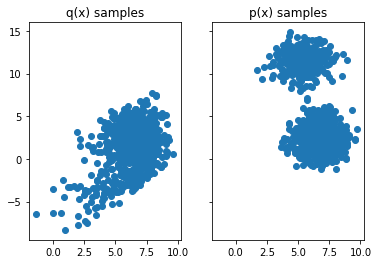

In [104]:
samples_fig_after = plot_samples(tester)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

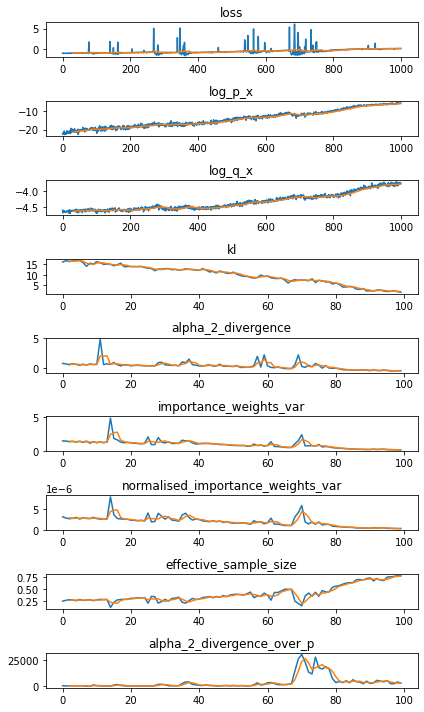

In [105]:
plot_history(history)

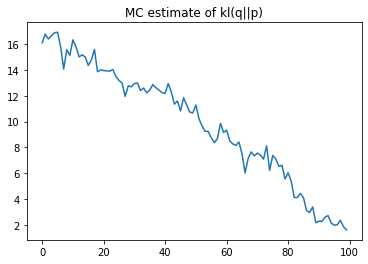

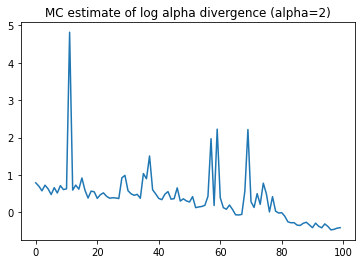

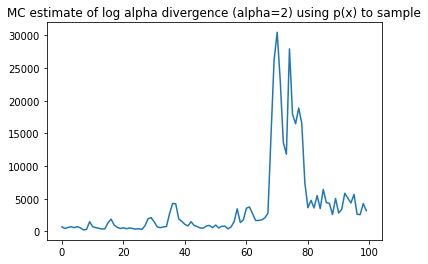

In [106]:
plot_divergences(history)

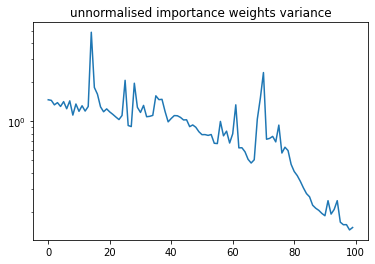

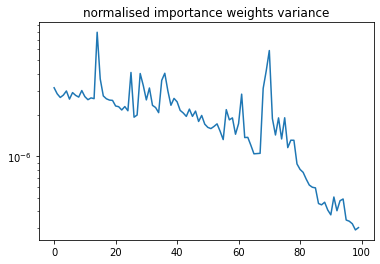

In [107]:
plot_sampling_info(history)

In [108]:
#fig_after_train = plot_distributions(tester)

In [109]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} \n"
     f"effective sample size after train is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 95.39286041259766 
estimate after training is 88.71727752685547 
effective sample size before is 128.14483642578125 
effective sample size after train is 7644.6640625 
variance in weights is 3.081328747711609e-09


## kl

In [110]:
torch.manual_seed(1) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

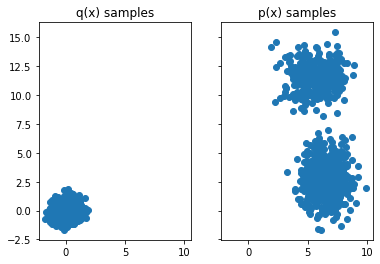

In [111]:
samples_before = plot_samples(tester)

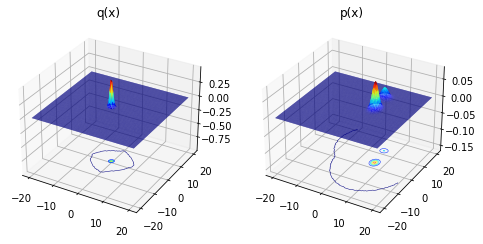

In [112]:
fig_before_train = plot_distributions(tester, bounds=[[-20, 20], [-20, 20]])

In [113]:
history = tester.train(1000, batch_size=100) # epochs 1000

loss: 1.9834376573562622, mean log p_x -3.555401086807251: 100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.53it/s]


In [114]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 4.599788188934326 
estimate before training is 6.899538516998291 
estimate after training is 87.48651885986328 
effective sample size before is 128.14483642578125 out of 10000
effective sample size after train is 285.7088928222656  out of 10000
variance in weights is 3.4004060012193804e-07


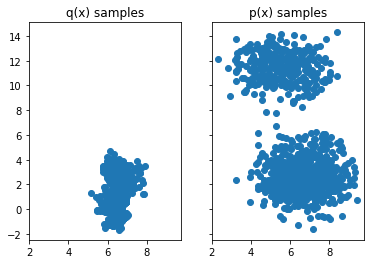

In [115]:
samples_after = plot_samples(tester)

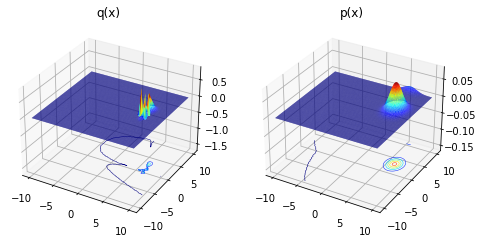

In [116]:
fig_after_train = plot_distributions(tester, )

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

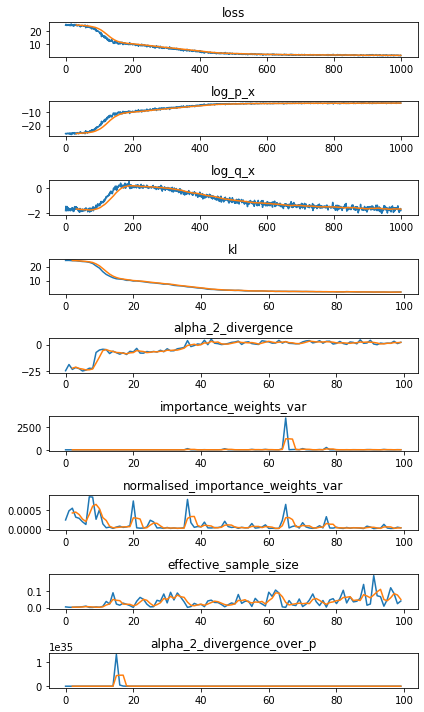

In [117]:
plot_history(history)

#  Lumpy many MoG

### Let's go

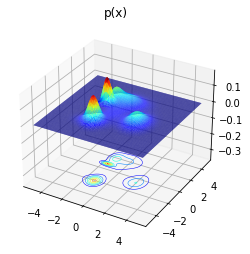

In [118]:
torch.manual_seed(0)
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=1.5)
fig = plot_distribution(target, bounds=[[-5, 5], [-5, 5]])
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))

In [119]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=2.0)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

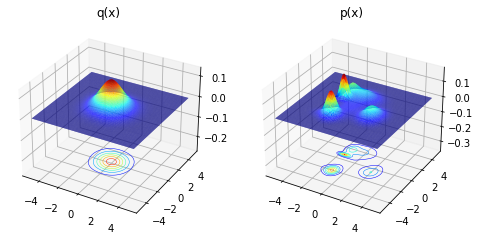

In [120]:
fig_before_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

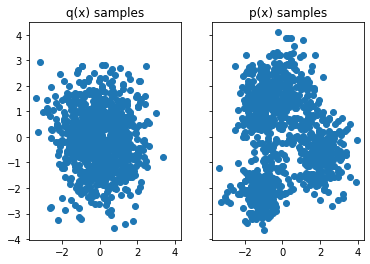

In [121]:
samples_fig_before = plot_samples(tester)

In [122]:
history = tester.train(1000, batch_size=int(1e3))

loss: -0.9232069253921509, mean log p_x -3.9387447834014893: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.18it/s]


In [123]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [124]:
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 5.078380584716797 
estimate before training is 5.1763129234313965 
estimate after training is 5.041360378265381 
effective sample size before is 2077.914306640625 out of 10000
effective sample size after train is 5105.60302734375  out of 10000
variance in weights is 9.587274973910098e-09


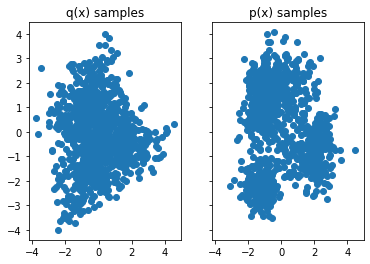

In [125]:
samples_fig_after = plot_samples(tester)

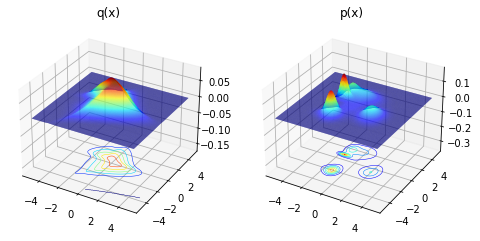

In [126]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]], n_points=200)

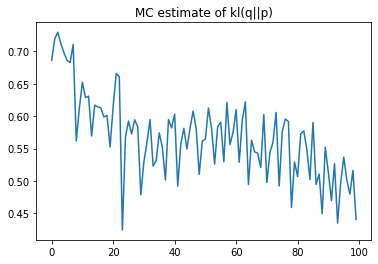

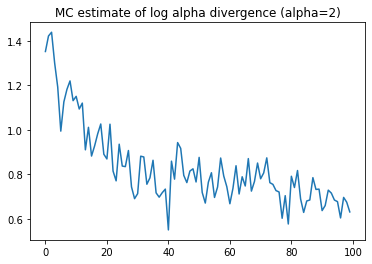

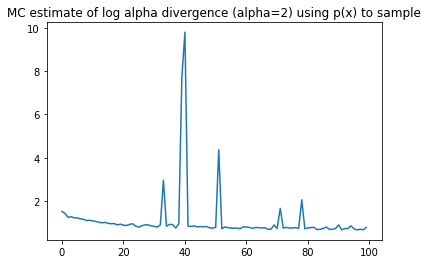

In [127]:
plot_divergences(history)

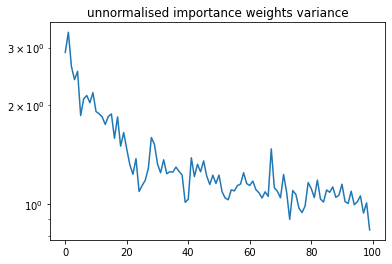

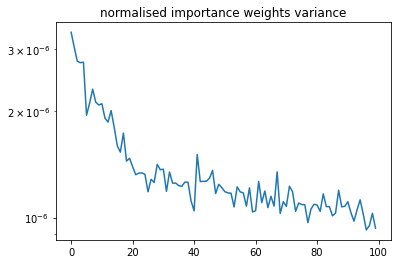

In [128]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

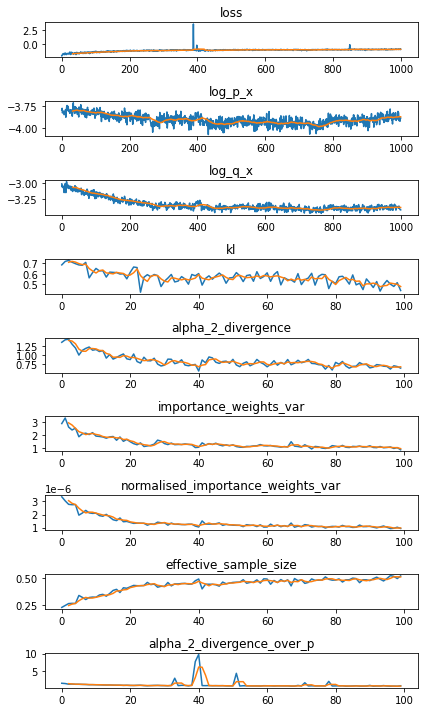

In [129]:
plot_history(history)

### Let's train a bit more

In [130]:
history = tester.train(2000, batch_size=int(1e3))

loss: -0.7089385986328125, mean log p_x -3.8404600620269775: 100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.77it/s]


In [131]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [132]:
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 5.078380584716797 
estimate before training is 5.1763129234313965 
estimate after training is 5.144598007202148 
effective sample size before is 2077.914306640625 out of 10000
effective sample size after train is 5589.3076171875  out of 10000
variance in weights is 7.89209320117834e-09


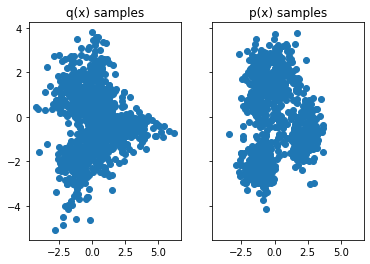

In [133]:
samples_fig_after = plot_samples(tester)

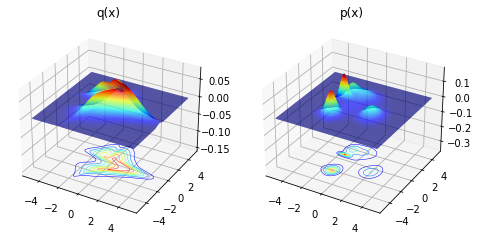

In [134]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]], n_points=200)

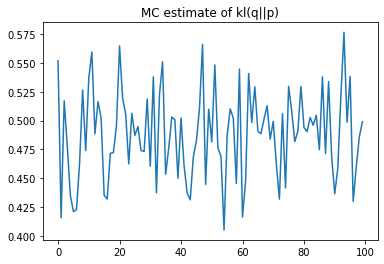

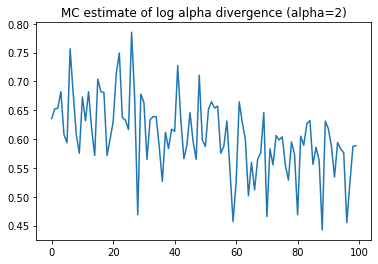

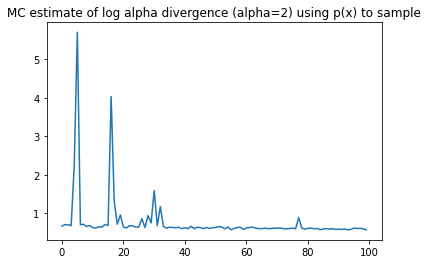

In [135]:
plot_divergences(history)

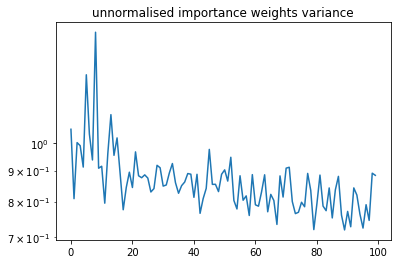

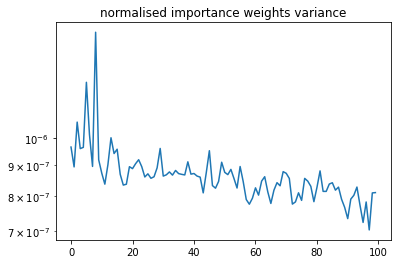

In [136]:
plot_sampling_info(history)

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

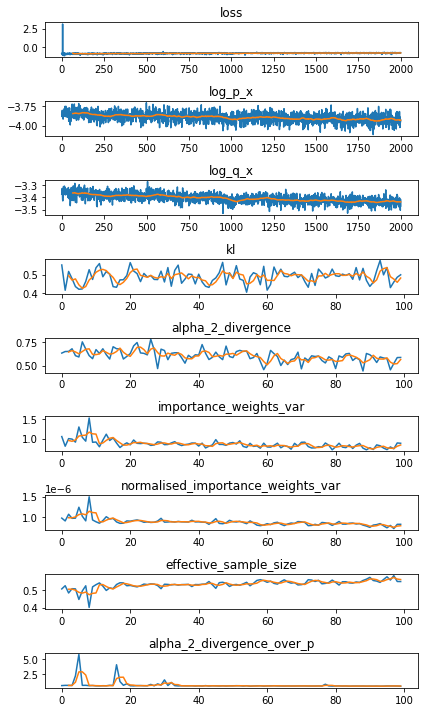

In [137]:
plot_history(history)

### KL

In [138]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
#expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

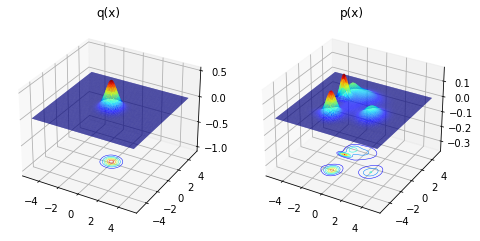

In [139]:
fig_before_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

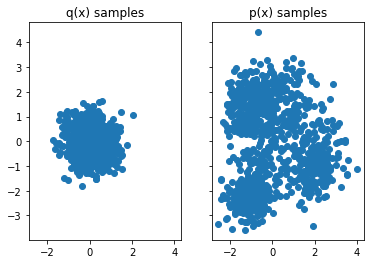

In [140]:
samples_fig_before = plot_samples(tester)

In [141]:
history = tester.train(10000, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 0.8246464729309082, mean log p_x -3.193415641784668: 100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:41<00:00, 98.67it/s]


In [142]:
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']}  out of {n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 5.078380584716797 
estimate before training is 5.1763129234313965 
estimate after training is 2.6959447860717773 
effective sample size before is 2077.914306640625 out of 10000
effective sample size after train is 2516.656005859375  out of 10000
variance in weights is 2.9738243867427627e-08


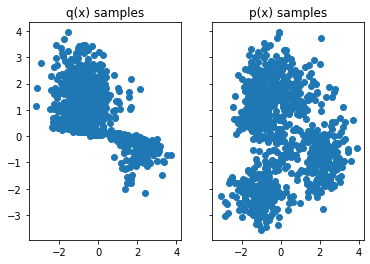

In [143]:
samples_fig_after = plot_samples(tester)

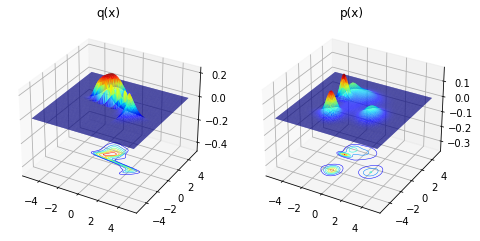

In [144]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

(<Figure size 432x720 with 9 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>],
       dtype=object))

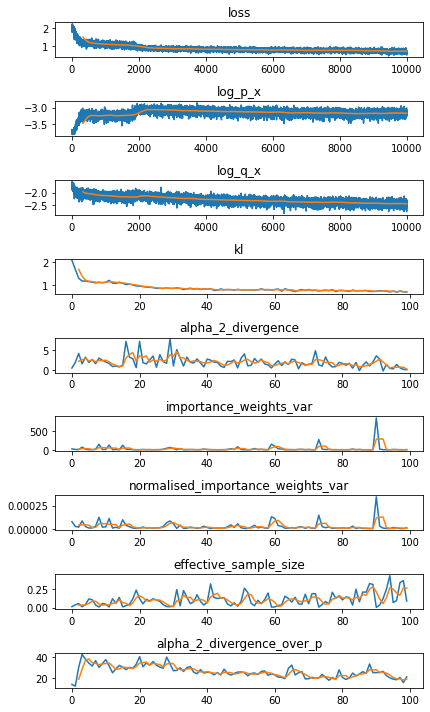

In [145]:
plot_history(history)

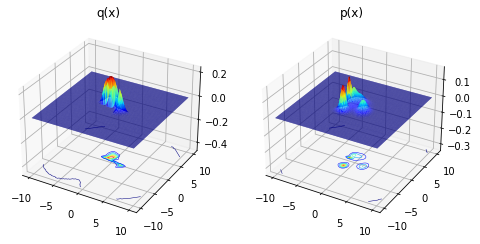

In [146]:
fig_before = plot_distributions(tester)

# New Section